# 환경 구성
1. keras 의 back end 로 open cl을 활용
2. 데이터 전처리에 pandas와 sklearn을 활용
3. 시각화를 위해 Matplotlib 사용

In [2]:
import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

'''
-----------------------------------------------------------------------------------------
Network Name         Inference Latency         Time / FPS
-----------------------------------------------------------------------------------------
mobilenet-opencl      24.60 ms                  2.89 ms / 345.84 fps
Correctness: PASS, max_error: 1.0642305824148934e-05, max_abs_error: 7.450580596923828e-07, fail_ratio: 0.0

mobilenet-cpu        411.35 ms                 408.90 ms / 2.45 fps
Correctness: PASS, max_error: 2.0418785425135866e-05, max_abs_error: 1.5869736671447754e-06, fail_ratio: 0.0
'''

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
# import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

df = pd.read_csv('./anoicos_prep.csv')
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M")
df = pd.pivot_table(df, index=['time']) + 0.000000001
df = df.fillna(df.mean())

# 데이터 전처리
## 훈련 데이터 선별 
1. 측정값에 대한 컬럼명 생성 및 확인
2. 설비의 동작여부를 나타내는 컬럼명 생성 및 선별 확인

## 라벨 생성
1. 데이터의 이상 유무를 판단할 수 있는 라벨은 따로 없음
1. 설비의 동작여부를 조합하여 설비의 동작시간에는 정상치 라벨을 / 동작하지 않는시간에는 비정상 라벨을 부여
1. 데이터 프레임을 Numpy array 로 변경

In [3]:
# 컬럼명 생성을 위한 코드테이블 - hard coding
operation_suffix = ['_ST', '_SF_ST', '_RF_ST']
#열원설비
hsource_suffix = ['_RTD','_STD']
hsource = ['M2.CH1', 'M2.CH1_1', 'M2.CH1_2', 'M3.CH2', 'PH_3.CT1', 'PH_2.CT2', 'PH_1.CT3', 'M4.HE']
#공조기
AHU_suffix = ['_SAT', '_RAT', '_RAH', '_EAD', '_OAT', '_OAD', '_MAT', '_MAD', '_CSV', '_CV', '_HV']
AHU = ['S2F.AHU4', 'S3F_1.AHU3F', 'S4F_1.AHU4F', 'S5F_1.AHU5F', 'S6F_1.AHU6F', 'S7F_1.AHU7F', 'S8F_1.AHU8F', 'S9F_1.AHU9F']

# 규칙에 따라 컬럼명을 조합하고, 컬럼명이 데이터프레임에 있는지 확인후 저장
cols = []
operation = []
for prefix in hsource+AHU:
    for suffix in hsource_suffix+AHU_suffix:
        target = prefix+suffix        
        if target in df.columns: 
            cols.append(target)
    for suffix in operation_suffix:
        opl = prefix+suffix
        if opl in df.columns: operation.append(opl)

# 라벨 생성 : 원하는 데이터들이 동작 여부가 모두 참 일경우 참으로 기록
df['label'] = (df[operation].sum(axis=1) >= len(operation)-17)

# 필요한 데이터만 필터링
cols.append('label')
df_prem = df[cols]

raw_data = df_prem.values

# display(df.head(10))
print('테이블 사이즈', df_prem.shape)

테이블 사이즈 (70158, 102)


# 라벨 지정 및 훈련데이터 분리 : train, test, label 등등
- sklearn 의 train_test_split 메소드를 사용하여 한번에 처리

In [4]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, :-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

whole = len(labels)
tr = len(train_labels)
te = len(test_labels)
print('총합 {}, 총합-훈련데이터={}, 훈련데이터 {}, 테스트 데이터 {}'.format(whole, whole-tr, tr, te))
print('훈련라벨 True = {}, 테스트 라벨 True = {}'.format(train_labels.sum(), test_labels.sum()))

# keras 업데이트후 텐서와 어레이간에 타입불일치생김. float 으로 명시적으로 변환해줌으로써 해결
train_data = train_data.astype(float)
test_data = test_data.astype(float)
train_labels = train_labels.astype(float)
test_labels = test_labels.astype(float)


총합 70158, 총합-훈련데이터=14032, 훈련데이터 56126, 테스트 데이터 14032
훈련라벨 True = 27022, 테스트 라벨 True = 6658


# 데이터 Nomalization : min max norm
- 컬럼 변수 간의 Scale 을 맞춰주기 위한 Nomalization 
- 간단하게 Min Max norm 을 사용

In [5]:
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
print (len(train_labels), len(test_labels))

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]
print (normal_train_data.shape, normal_test_data.shape)

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]
print (anomalous_train_data.shape, anomalous_test_data.shape)


56126 14032
(27022, 101) (6658, 101)
(29104, 101) (7374, 101)


# Normal / Anomal 데이터간의 비교
- 모델링 편의상 나눠놓은 상태이므로 정상/비정상 여부에 대한 신뢰도는 떨어짐
- 정상 데이터로만 모델링 예정이므로, 다음 단계에서 자가 재구성 신뢰도를 판단하기 위한 척도로만 의미를 부여

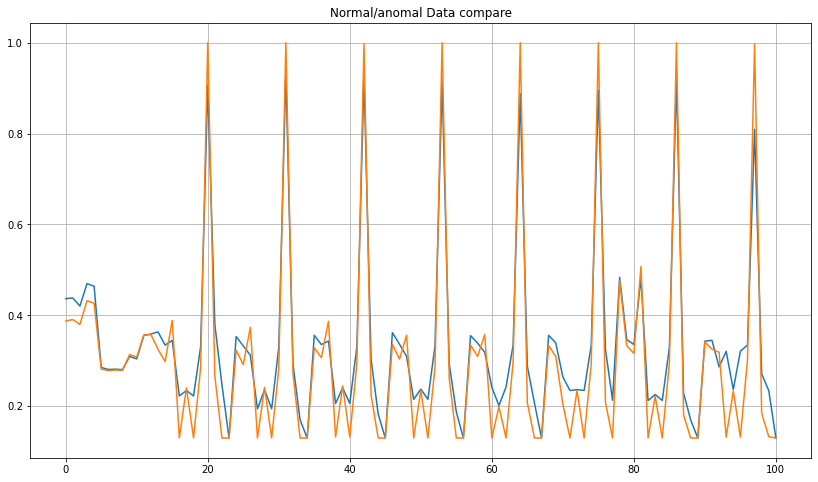

In [6]:
plt.figure(figsize=(14,8))
plt.grid()
# plt.plot(np.arange(101), normal_train_data[0])
# plt.plot(np.arange(101), anomalous_train_data[0])
plt.plot(np.arange(101), normal_train_data.numpy().mean(axis=0))
plt.plot(np.arange(101), anomalous_train_data.numpy().mean(axis=0))
plt.title("Normal/anomal Data compare")
plt.show()

# 모델 빌드

In [7]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(101, activation="sigmoid")])

  def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')


# 훈련 진행
## Custom Callback 을 정의하고 모델훈련을 진행
## Callback 은 사용하지 않아도 무방하며, 훈련이나 추론시간이 오래걸릴경우 중간 확인용으로 사용

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))


history = autoencoder.fit   (normal_train_data, normal_train_data, 
                            epochs=150, 
                            batch_size=128,
                            validation_data=(normal_test_data, normal_test_data),
                            shuffle=True)

# 학습 곡선
- Training loss 와 Validation loss가 수렴하는 것이 관찰됨
  - 둘사이에 차이가 별로 없음
  - 주어진 정보 만으로 self reconstruction 이 잘될수 있을 것으로 판단됨

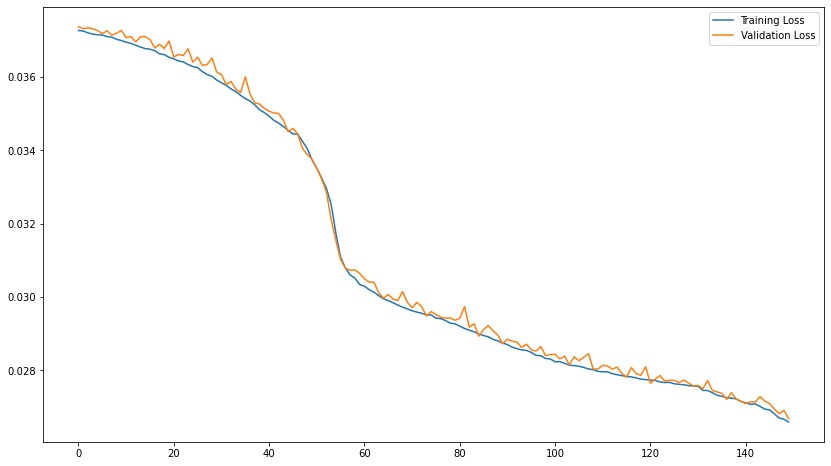

In [13]:
plt.figure(figsize=(14,8))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

# 입력 / 출력 값 비교 (정상 데이터)
- 입출력 값의 오차가 별로 없음
- 자가 재구성이 잘 되는 것으로 보임
  - 정상 데이터를 정제해서 모델링을 할 경우 이상치 탐지에 활용할 수 있을 가능성 높음
  - 단, 현재는 훈련 편의상 정상/비정상 데이터를 나누었으나, 나눈 기준이 애매하여 크게 의미를 두기 어려움


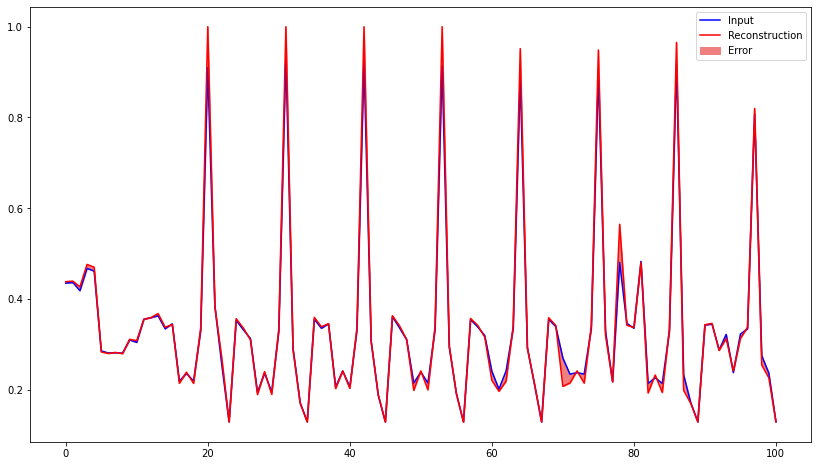

In [14]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(14,8))
plt.plot(normal_test_data.numpy().mean(axis=0), 'b')
plt.plot(decoded_imgs.mean(axis=0), 'r')
plt.fill_between(np.arange(101), decoded_imgs.mean(axis=0), normal_test_data.numpy().mean(axis=0), color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

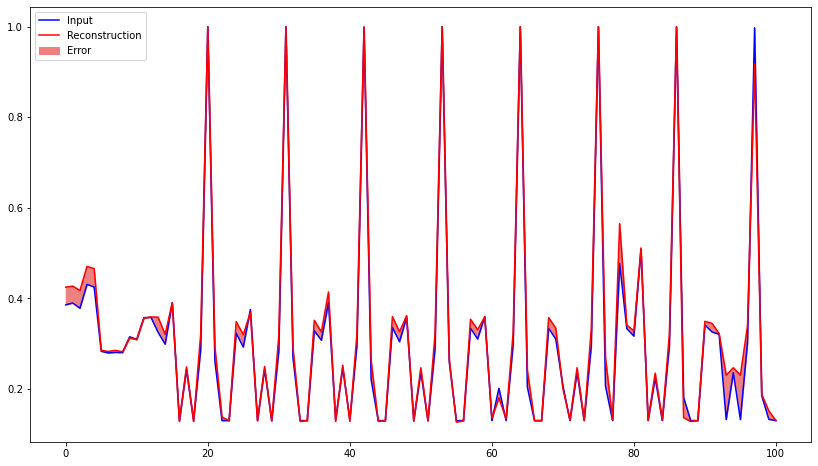

In [15]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(14,8))
plt.plot(anomalous_test_data.numpy().mean(axis=0), 'b')
plt.plot(decoded_imgs.mean(axis=0), 'r')
plt.fill_between(np.arange(101), decoded_imgs.mean(axis=0), anomalous_test_data.numpy().mean(axis=0), color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# 평가
1. I-Cos 데이터는 시계열 정보를 이용하지 않아도 순간 데이터를 추론하는데 충분한 정보를 가지고 있는 것으로 **보임**
   1. 보다 정확한 평가를 위하여 자가 재구성효율을 **정략적 수치로 표현할 필요가 있음**   
2. 타겟 설비의 이상여부 판단을 어떻게 할지 고민하고 구현할 필요가 있음3. 